# Telco Churn Project

- Brad Gauvin 13 Jul 2022

In [1]:
# Environment Set up
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pydataset import data
import plotly
import plotly.graph_objs as go
import eli5

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model

import warnings
warnings.filterwarnings("ignore")

### Project Goal

 - The project goals focus on identifying customers and drivers of churn. Statistical testing and machine learning models are used to find factors of churn and make recommendations to Telco for reducing churn.
 

## Acquire Data

 - Data was acquired through the CodeUp mySQL server through the acquire.py file
``` 
select * FROM customers
join contract_types using (contract_type_id)
join internet_service_types using (internet_service_type_id)
join payment_types using (payment_type_id)
```

In [2]:
# Acquire Data
df=get_telco_data()

Using cached csv


## Prepare Steps:
 - Using prepare.py:
     - Payment type, internet service type, and contract type were dropped
     - Total charges was adjusted to dtype float
     - Columns were encoded for future analysis
     - duplicate columns were dropped after encoding
     - Some columns were renamed for clarity

In [3]:
# Run acquired data through prepare script and split into train, validate and test sets
df = prep_telco(df)
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

- Preparation results:
   - Data split into train, validate, and test

## Exploratory Analysis

- Initial Questions
   - What customer factors are available in the data?
   - What business factors are available in the data?
   - What factors contribute the most to churn from the customers?
   - What factors from the business have the highest contribution to churn?

<span style = 'color:red'>First look at Data highlights answers to first two questions:</span>

Customer groups
 - Senior citizen
 - Male vs. Female
 - Partner vs. No Partner
 - Dependent vs No Dependents

Business Groups
 - Auto vs Manual Pay
 - paperless billing vs mailed
 - month-to-month vs contracted
 - Internet vs no Internet
 - Phone vs No phone

#### Baseline Identified


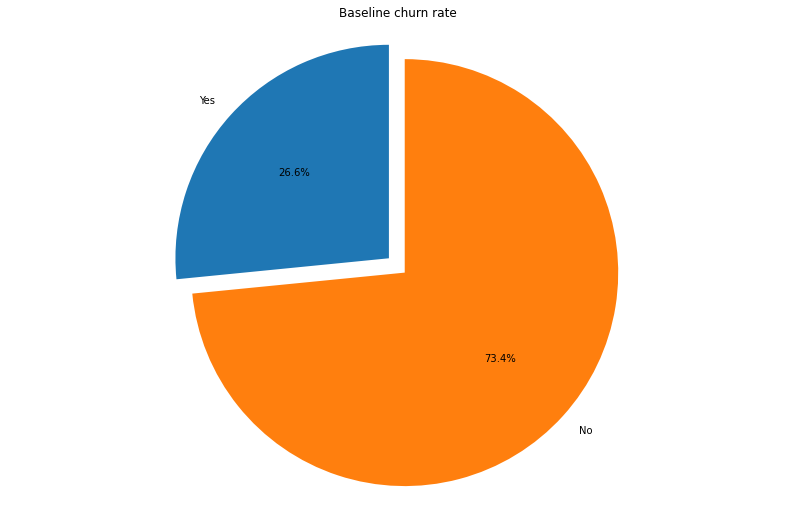

In [4]:
# Baseline Churn
baseline=pd.DataFrame({'Yes':train.churn.sum(), 'No': (train.churn==0).sum()}, index = ['churn']).T
sizes = baseline.churn
labels = baseline.index
explode = (0, 0.1)
fig1, ax1=plt.subplots(figsize=(14,9))
# Look at Pie chart as baseline
p = ax1.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', startangle = 90)
p=ax1.axis('equal')
p=plt.title('Baseline churn rate')

#### Correlations
  - Started analysis with idea of correlating variables.
  - Looking for variables with churn rate above 26%
  
#### Looking to identify which variables have higher than average churn rates.
   - Assumptions:
      - Customer information and business information are key points
      - Customer Groups of gender, senior citizen parter, and dependents focus on customer data
      - Business group of paperless billing, autopay, month-to-month contracts, phone service, internet service, and streaming services.
      
  #### Key questions:
  - What factors contribute the most to churn from the customers?
  - What factors from the business have the highest contribution to churn?

In [5]:
# Loop through variables - Tookout observed rates for final product - uncomment to see
alpha = 0.05
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service','has_streaming']
reject_null = []
churn_rate=[]
baseline_churn = (train.churn == 1).mean()
for group in groups:
    observed = pd.crosstab(train.churn, train[group])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    #print(group)
    #print('Observed\n')
    #print(observed.values)
    #print('---\nExpected\n')
    #print(expected.astype(int))
    #print('---\n')
    #print(f'chi^2 = {chi2:.4f}')
    #print(f'p     = {p:.4f}')
    #if p < alpha:
        #print("We reject the null hypothesis")
    #else:
        #print("We fail to reject the null hypothesis")
    churn_rate.append((train.churn[train[group] == 1]).mean())
    reject_null.append(p<alpha)
    
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
results = results.sort_values(by= 'churn_rate')

Text(109.0, 0.5, 'Churn Rate')

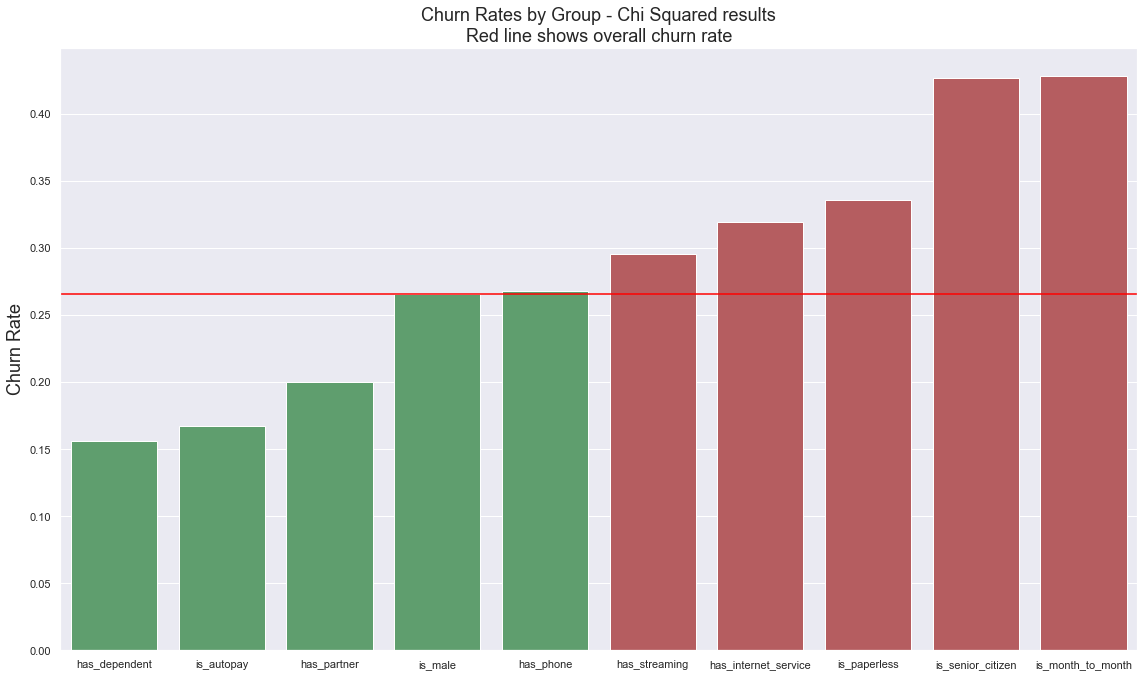

In [6]:
# Plot bar plot of results, highlighting which groups we can reject the null hypothesis - ie there is a relationshio
sns.set(rc={'figure.figsize':(16,9)})
colors = ('g','g','g','g','g','r','r','r','r','r')
sns.barplot(data = results, x = results.index ,y = 'churn_rate', palette = colors)
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nRed line shows overall churn rate', fontsize = 18)
plt.axhline(y=baseline_churn, color = 'red')
plt.ylabel('Churn Rate', fontsize = 18)

### <span style = 'color:red'> Recommend focusing on these areas for reducing churn by rate of churn </span>
 - Month-to-month: 42.8%
 - Senior citizens: 42.7%
 - Paperless billing: 33.6%
 - internet service: 32.0%
 - Streaming: 29.5%

In [7]:
# Identifying variables for further analysis
internet = train[train.has_internet_service == 1]
paperless = train[train.is_paperless == 1]
senior = train[train.is_senior_citizen == 1]
streaming = train[train.has_streaming == 'yes']

observation1=pd.crosstab(internet.churn, internet.internet_service_type)
observation1

internet_service_type,DSL,Fiber optic
churn,,
0,1101,987
1,247,735


In [8]:
observation2=pd.crosstab(paperless.churn, paperless.payment_type)
observation2

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
0,388,427,481,248
1,104,104,474,98


### Does the type of internet service (Fiber vs DSL) have a relationship with whether a customer will churn?

[Text(0.5, 0, 'DSL'), Text(1.5, 0, 'Fiber optic')]

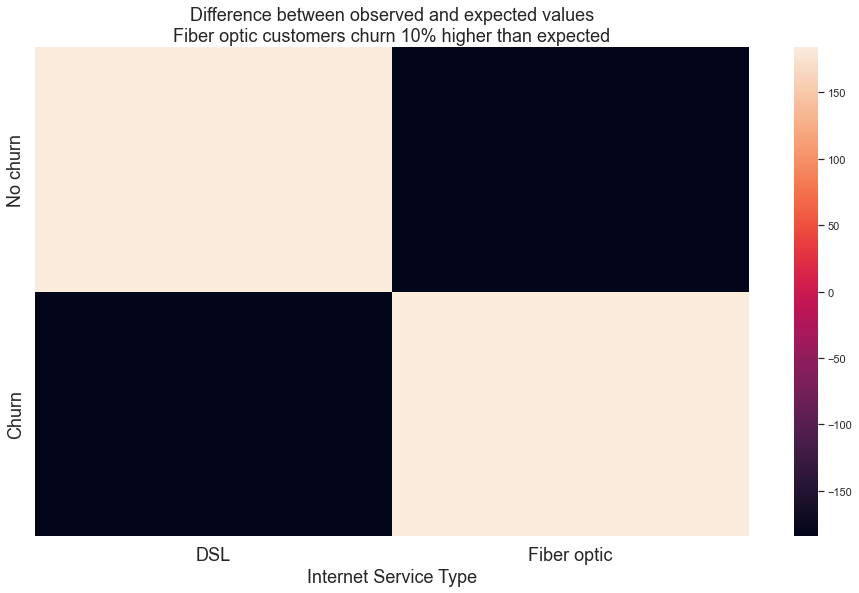

In [9]:
# create a dataframe of just internet customers from train
internet = train[train.has_internet_service == 1]
# create the observed dataframe of churn vs service type
observed = pd.crosstab(internet.churn, internet.internet_service_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)
# create heatmap showing observed vs expected
observed.index.name=""
expected_df = pd.DataFrame(expected,index=[0,1], columns=['DSL','Fiber optic'])
observed - expected_df
ax = sns.heatmap(data = observed-expected_df, yticklabels=['No churn','Churn'])
ax.set_title('Difference between observed and expected values\nFiber optic customers churn 10% higher than expected', fontsize = 18)
ax.set_xlabel('Internet Service Type', fontsize = 18)
ax.set_yticklabels(['No churn','Churn'],fontsize = 18)
ax.set_xticklabels(['DSL','Fiber optic'],fontsize = 18)

## Model Testing

In [10]:
# Baseline churn rate
baseline_churn = (train.churn == 1).mean()
baseline_churn

0.2656845313690627

In [11]:
# Prepping data after reindexing
# Determine the categorical variables - here defined as object data type (non-numeric) and with fewer than 5 values
catcol = df.columns[(df.nunique()<5)&(df.dtypes == 'object')]
# Encode categoricals
dummy_df = pd.get_dummies(df[catcol], dummy_na=False, drop_first=True)
# Concatenate dummy df to original df
df = pd.concat([df,dummy_df],axis=1)
# Remove the original categorical columns after encoding
df = df.drop(columns=catcol)
df=df.drop(columns = ['has_streaming'])

In [12]:
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

In [13]:
# Defining Features
features = ['monthly_charges','is_autopay','is_paperless','internet_service_type_Fiber optic', 'payment_type_Electronic check']
target = 'churn'

In [14]:
x_train = train[features]
y_train = train[[target]]

x_validate = validate[features]
y_validate = validate[[target]]

x_test = test[features]
y_test = test[[target]]

## Decision Tree

In [15]:
def decision_tree_train(x_train, y_train, features=features, target=target, d = 10, m=1, print_results = True):
  
    # Decition tree data variables
    clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf = m, random_state=123)
    clf = clf.fit(x_train, y_train)
    accuracy = clf.score(x_train, y_train)
    y_pred = clf.predict(x_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    # True Neg, False Pos, False Neg, False Pos
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    # Metrics
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print("----------------")
        print(f"Accuracy score on training set is: {accuracy:.2f}")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    #building train report
    train_report = {'d':clf.max_depth, 
                    'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def classifier_validate(x_validate, y_validate, clf, print_results=True):
    d = clf.max_depth
    accuracy = clf.score(x_validate, y_validate)


    # Produce y_predictions that come from the x_validate
    y_pred = clf.predict(x_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {selected_features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'d':clf.max_depth, 
                       'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [16]:
#Results Commented out
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = decision_tree_train(x_train, y_train, d=d, m = min_sample , print_results=False)
        validate_report = classifier_validate(x_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])
        
train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

clf_combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
clf_combined_df["accuracy_diff"] = clf_combined_df.accuracy_validate-clf_combined_df.accuracy_train
clf_combined_df["precision_diff"] = clf_combined_df.precision_validate-clf_combined_df.precision_train
clf_combined_df["recall_diff"] = clf_combined_df.recall_validate-clf_combined_df.recall_train

clf_combined_df = clf_combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
#print(f"Highest accuracy score on train:\n {clf_combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
#print(f"Highest accuracy score on validate:\n{clf_combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
#print(f"This was a drop-off from train of:\n{clf_combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
#print(f"Lowest drop-off in accuracy from train to validate:\n {clf_combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

decision_tree_final_results = clf_combined_df
decision_tree_final_results["model"] = 'decision_tree'

## Random Forest

In [17]:
# Results Commented out
def random_forest(train, validate,features , min_samples_leaf, d, print_results = True):
    
    x_train = train[features]
    y_train = train[['churn']]
    rf = RandomForestClassifier(max_depth=d, min_samples_leaf=min_samples_leaf, random_state=123)
    # Fit
    rf = rf.fit(x_train, y_train['churn'])
    
    # Predict
    y_pred = rf.predict(x_train)
    
    # Results
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    if print_results:
        print("TRAINING RESULTS")
        print("----------------")
        # Feature importance
        print(f"Feature importance:\n{dict(zip(features,rf.feature_importances_))}")
        print(f"Accuracy of random forest classifer on training set: {rf.score(x_train, y_train):.2%}")
        print(classification_report(y_train, y_pred))

        
        print("Confusion matrix: rows are truth, columns are pred")
        print("")
        print(confusion_matrix(y_train, y_pred))
        print("")
        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    train_report = classification_report(y_train, y_pred, output_dict=True)
    ### Predict for Validate 
    y_pred_val = rf.predict(validate[features])
    ### Classification report
    validate_report = classification_report(validate[['churn']],y_pred_val, output_dict=True)
    if print_results:
        print("VALIDATE RESULTS")
        print("----------------")
        print(classification_report(validate[['churn']],y_pred_val))
    reports = {'train':train_report,'validate':validate_report}
    return reports

#random_forest(train,validate,features,1,10,True)

In [18]:
#Loop to see depth rand 1-10; Commented out print results
for i in range (2,11):
    rfc = RandomForestClassifier(max_depth=i, random_state=123)
    rfc = rfc.fit(x_train,y_train)
    #predictions
    y_pred = rfc.predict(x_train)
    # Classification loop
    report = classification_report(y_train, y_pred, output_dict=True)
    #print(f'Tree with max depth of {i}')
    #print(pd.DataFrame(report))
    #print()

In [19]:
# Commented out results
metrics = []

for i in range(1, 25):
    # Make the model
    rfc = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    rfc = rfc.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = rfc.score(x_train, y_train)
    
    out_of_sample_accuracy = rfc.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
rf_df = pd.DataFrame(metrics)
rf_df["difference"] = rf_df.train_accuracy - rf_df.validate_accuracy
#rf_df

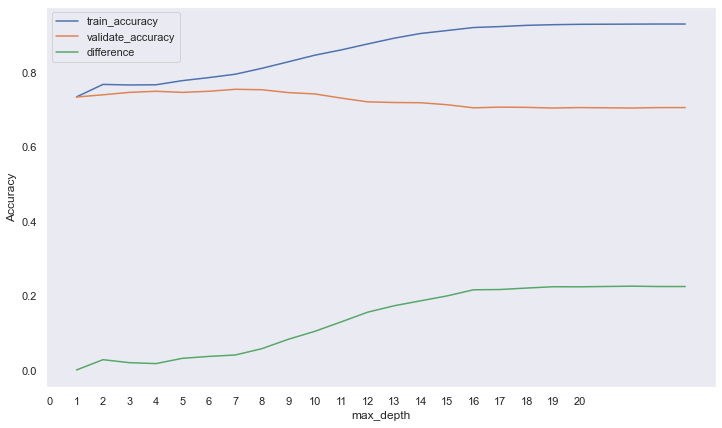

In [20]:
rf_df.set_index('max_depth').plot(figsize = (12,7))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

## KNN

In [21]:
def knn_train(x_train, y_train, eatures=features, target=target, k=1, print_results = True):
  
    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    accuracy = clf.score(x_train, y_train)
    y_pred = clf.predict(x_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {features}")
        print(f"K of {clf.n_neighbors}")
        print("----------------")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def knn_validate(x_validate, y_validate, clf, print_results=True):
    accuracy = clf.score(x_validate, y_validate)


    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(x_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {features}")
        print(f"K of {clf.n_neighbors}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [39]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

k_range = range(1,100)
for k in k_range:

    clf, train_report = knn_train(x_train, y_train, k=k, print_results=False)
    validate_report = knn_validate(x_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

knn_combined_df = train_results_df.merge(validate_results_df,on=['k'], suffixes=['_train','_validate'])
knn_combined_df["accuracy_diff"] = knn_combined_df.accuracy_validate-knn_combined_df.accuracy_train
knn_combined_df["precision_diff"] = knn_combined_df.precision_validate-knn_combined_df.precision_train
knn_combined_df["recall_diff"] = knn_combined_df.recall_validate-knn_combined_df.recall_train

knn_combined_df = knn_combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {knn_combined_df.accuracy_train.max()} with k setting of {knn_combined_df.k[knn_combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {knn_combined_df.accuracy_validate.max()} with k setting of {knn_combined_df.k[knn_combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {knn_combined_df.accuracy_diff.min()} with k setting of {knn_combined_df.k[knn_combined_df.accuracy_diff == knn_combined_df.accuracy_diff.min()].array[0]}")

knn_final_results = knn_combined_df
knn_final_results["model"] = 'k_nearest_neighbors'

Highest accuracy score on train:
 0.9171958343916687 with k setting of 1
Highest accuracy score on validate:
 0.7511848341232228 with k setting of 26
Lowest drop-off in accuracy from train to validate:
 -0.22939962586086304 with k setting of 1


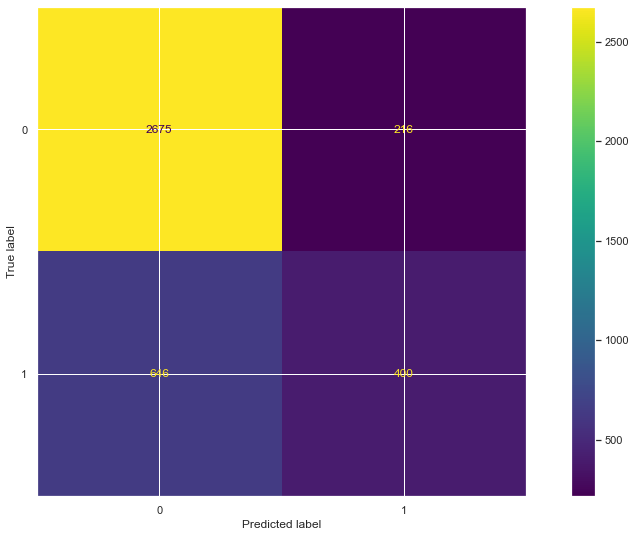

In [23]:
k=26
knn = KNeighborsClassifier(n_neighbors = k)
knn = knn.fit(x_train, y_train)
plot_confusion_matrix(knn,x_train, y_train)

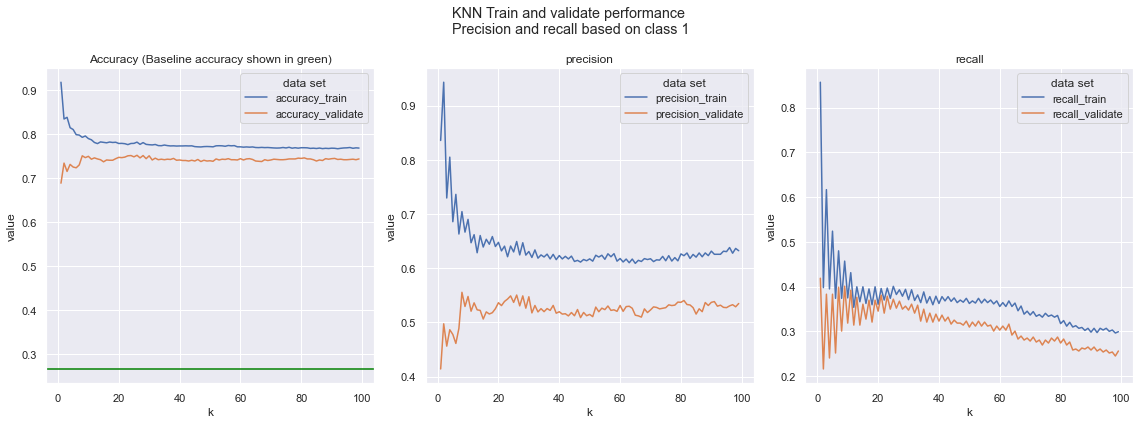

In [24]:
# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(knn_combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['k'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].k, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'KNN Train and validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_churn, color = 'green')

## Logistical Regression

In [25]:
def logistic_regression(train, features, target, c, validate = None, test = None, print_results = True):
    
    x_train = train[features]
    y_train = train[target]
    logit = LogisticRegression(C=c,random_state=123, max_iter=1000)
    # Fit
    logit = logit.fit(x_train, y_train)
    
    # Predict
    y_pred = logit.predict(x_train)
    
    # Results
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    if print_results:
        print("----------------")
        print(f"USING c OF {logit.C}")
        print("TRAINING RESULTS")
        print("----------------")
        # Feature importance
        print(selected_features)
        print('Coefficient: \n', logit.coef_)
        print('Intercept: \n', logit.intercept_)
        
        
        print(f"Accuracy of logistic regression classifer on training set: S{logit.score(x_train, y_train):.2%}")
        print(classification_report(y_train, y_pred))

        
        print("Confusion matrix: rows are truth, columns are pred")
        print("")
        print(confusion_matrix(y_train, y_pred))
        print("")
        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    train_report = classification_report(y_train, y_pred, output_dict=True)
    if validate is not None:
        ### Predict for Validate 
        y_pred_val = logit.predict(validate[features])
        ### Classification report
        validate_report = classification_report(validate[target],y_pred_val, output_dict=True)
        if print_results:
            print("----------------")
            print(f"USING c OF {logit.C}")
            print("VALIDATE RESULTS")
            print("-------Logistic Regression---------")
            print(classification_report(validate[target],y_pred_val))
    else:
        validate_report = None
        
    ## Test set performance
    if test is not None:
        ### Predict for Validate 
        y_pred_test = logit.predict(test[features])
        ### Classification report
        test_report = classification_report(test[target],y_pred_test, output_dict=True)
        if print_results:
            print("----------------")
            print(f"USING c OF {logit.C}")
            print("TEST RESULTS")
            print("-------Logistic Regression---------")
            print(classification_report(test[target],y_pred_test))
    else:
        test_report = None
    reports = {'train':train_report,'validate':validate_report, 'test':test_report}
    return reports

# Performance Report 


def plot_train_validate_performance(train_results_df, validate_results_df):
    # Combine train and validate results to allow for plotting together
    lr_combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
    lr_combined_df["accuracy_diff"] = lr_combined_df.accuracy_validate-combined_df.accuracy_train
    lr_combined_df["precision_diff"] = lr_combined_df.precision_validate-combined_df.precision_train
    lr_combined_df["recall_diff"] = lr_combined_df.recall_validate-combined_df.recall_train
    
    # Melt metrics into same column to enable clean plotting with seaborn
    data = pd.melt(lr_combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']),
                   id_vars =['c'], var_name='metric')
    
    # Plot train and validate performance
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy","precision","recall"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                     y = data[data.metric.str.contains(metric)].value, 
                     hue = data[data.metric.str.contains(metric)].metric,  
                     ax=ax[i])

        plt.suptitle('Train and validate performance')
        plt.tight_layout()

        ax[i].legend(title = 'data set')
        ax[i].set_title(metric)
        # if metric == "accuracy":
        #     ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        #     ax[i].axhline(baseline_accuracy, color = 'green')
    
    # Plot performance difference between train and validate
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy_diff","precision_diff","recall_diff"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = combined_df.c, y = combined_df[metric], ax=ax[i])
        plt.suptitle('Difference between validate and train performance')
        ax[i].set_title(metric)
        plt.tight_layout()
    
    return lr_combined_df

In [26]:
#Logistical regression data points to be copy and pasted from Modeling.py 
cs =[]
accuracies = []
precisions = []
recalls = []
v_accuracies = []
v_precisions = []
v_recalls = []
c_values = [0.01, 0.1, 1, 10, 100, 1000]

for c in np.arange(0.01, 2.00, 0.1):
    cs.append(c)
    reports = logistic_regression(train, features, target, c, validate, None, False)

    #Train Reports
    train_report = reports['train']
    accuracies.append(train_report['accuracy'])
    precisions.append(train_report['1']['precision'])
    recalls.append(train_report['1']['recall'])

    #Validate Reports
    validate_report = reports['validate']
    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['1']['precision'])
    v_recalls.append(validate_report['1']['recall'])
        
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":accuracies,"precision":precisions,"recall":recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,
                                          "recall":v_recalls})

In [30]:
def plot_train_validate_performance(train_results_df, validate_results_df):
    # Combine train and validate results to allow for plotting together
    lr_combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
    lr_combined_df["accuracy_diff"] = lr_combined_df.accuracy_validate-lr_combined_df.accuracy_train
    lr_combined_df["precision_diff"] = lr_combined_df.precision_validate-lr_combined_df.precision_train
    lr_combined_df["recall_diff"] = lr_combined_df.recall_validate-lr_combined_df.recall_train
    
    # Melt metrics into same column to enable clean plotting with seaborn
    data = pd.melt(lr_combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['c'], var_name='metric')
    
    # Plot train and validate performance
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy","precision","recall"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                     y = data[data.metric.str.contains(metric)].value, 
                     hue = data[data.metric.str.contains(metric)].metric,  
                     ax=ax[i])

        plt.suptitle('Train and validate performance')
        plt.tight_layout()

        ax[i].legend(title = 'data set')
        ax[i].set_title(metric)
        # if metric == "accuracy":
        #     ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        #     ax[i].axhline(baseline_accuracy, color = 'green')
    
    # Plot performance difference between train and validate
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy_diff","precision_diff","recall_diff"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = lr_combined_df.c, y = lr_combined_df[metric], ax=ax[i])
        plt.suptitle('Difference between validate and train performance')
        ax[i].set_title(metric)
        plt.tight_layout()
    
    return lr_combined_df

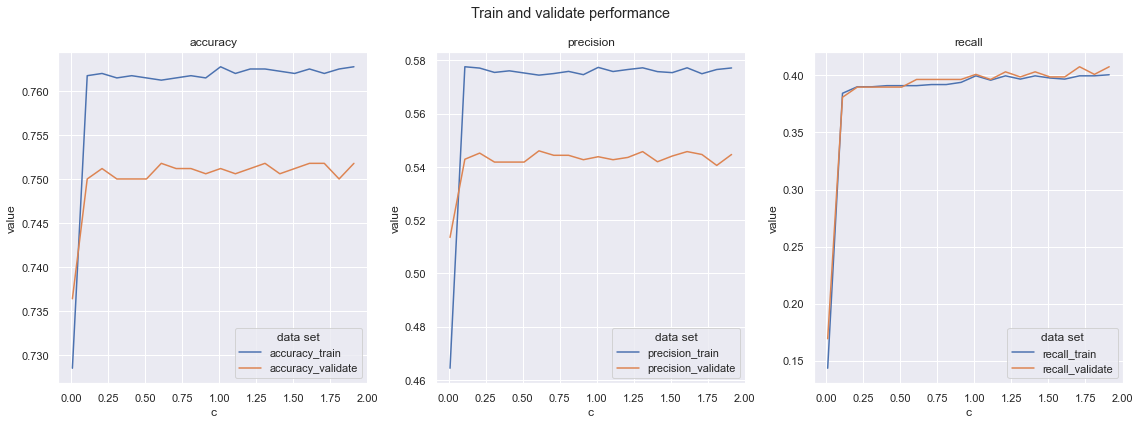

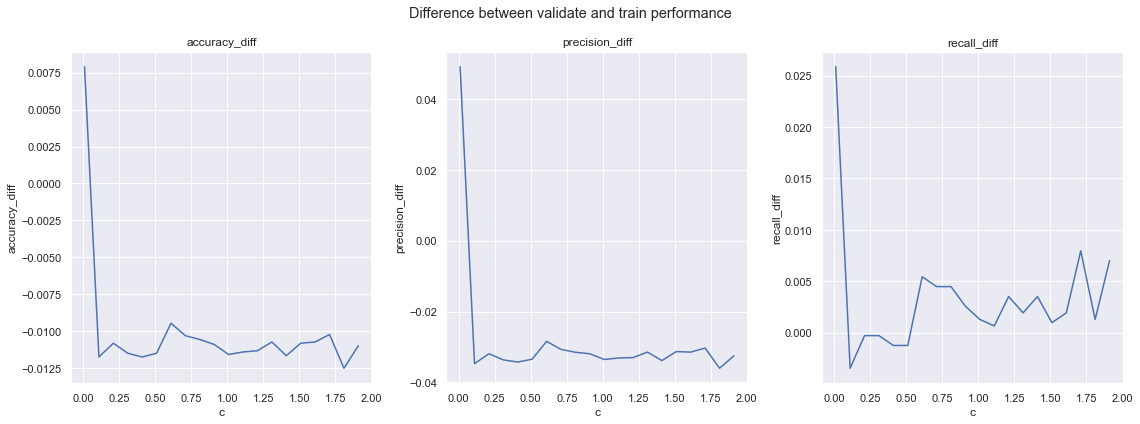

In [31]:
lr_combined_df = plot_train_validate_performance(train_results_df, validate_results_df)

## Test Phase
- Using KNN as test based on 91% accuracy rating. All validate scores were low

In [40]:
# Change validate to test
k=26
knn = KNeighborsClassifier(n_neighbors = k)
knn = knn.fit(x_test, y_test)
features = ['monthly_charges', 'is_autopay', 'is_paperless',
       'internet_service_type_Fiber optic', 'payment_type_Electronic check']
knn, train_report = knn_train(x_test, y_test,features, target, 26, print_results=False)
accuracy = knn.score(x_test, y_test)



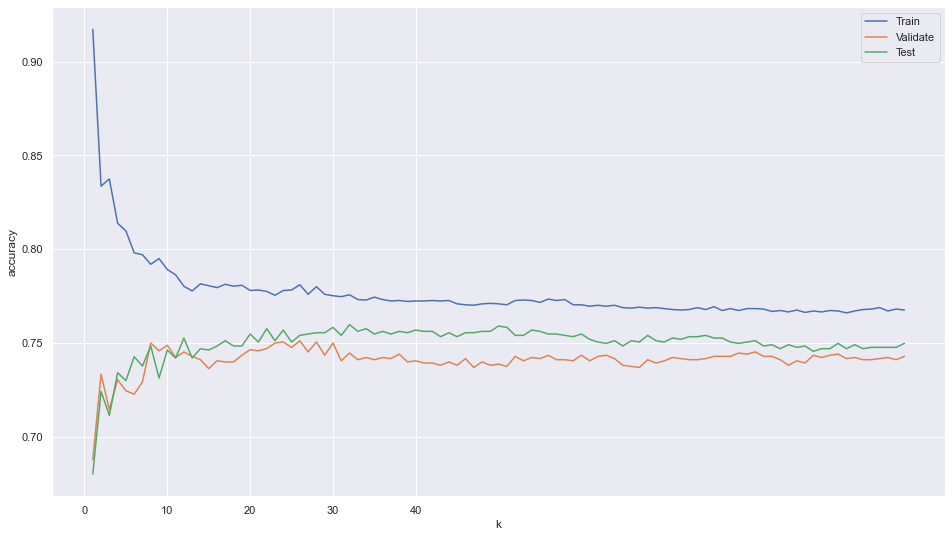

In [42]:
import matplotlib.pyplot as plt
k_range = range(1, 100)
train_scores = []
validate_scores = []
test_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    train_scores.append(knn.score(x_train, y_train))
    validate_scores.append(knn.score(x_validate, y_validate))
    test_scores.append(knn.score(x_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_range, train_scores, label='Train')
plt.plot(k_range, validate_scores, label='Validate')
plt.plot(k_range, test_scores, label='Test')
plt.legend()
plt.xticks([0,10,20,30,40])
plt.show()

In [46]:
knn1t = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn26t = KNeighborsClassifier(n_neighbors=26, weights='uniform')
knn1t.fit(x_train, y_train)
knn26t.fit(x_train,y_train)
knn1v = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn26v = KNeighborsClassifier(n_neighbors=26, weights='uniform')
knn1v.fit(x_validate, y_validate)
knn26v.fit(x_validate, y_validate)
knn1test = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn26test = KNeighborsClassifier(n_neighbors=26, weights='uniform')
knn1test.fit(x_test, y_test)
knn26test.fit(x_test,y_test)

KNeighborsClassifier(n_neighbors=26)

In [48]:
print('Accuracy of KNN (k=1) classifier on train set: {:.2f}'
     .format(knn1t.score(x_train, y_train)))

print('Accuracy of KNN (k=26) classifier on train set: {:.2f}'
     .format(knn26t.score(x_train, y_train)))

print('Accuracy of KNN (k=1) classifier on validate set: {:.2f}'
     .format(knn1v.score(x_validate, y_validate)))

print('Accuracy of KNN (k=26) classifier on validate set: {:.2f}'
     .format(knn26v.score(x_validate, y_validate)))

print('Accuracy of KNN (k=1) classifier on test set: {:.2f}'
     .format(knn1test.score(x_test, y_test)))

print('Accuracy of KNN (k=26) classifier on test set: {:.2f}'
     .format(knn26test.score(x_test, y_test)))

Accuracy of KNN (k=1) classifier on train set: 0.92
Accuracy of KNN (k=26) classifier on train set: 0.78
Accuracy of KNN (k=1) classifier on validate set: 0.96
Accuracy of KNN (k=26) classifier on validate set: 0.77
Accuracy of KNN (k=1) classifier on test set: 0.96
Accuracy of KNN (k=26) classifier on test set: 0.76


# Conclusion

## Baseline accuracy 73%
## Test accuracy: 78% on K26
## Validate Accuracy: 77% on K26
## Test Accurcacy 76% of K 26

# Takeaway

 - Accuracy improved about 3% over baseline
 
 # Recommendation
 - I would recommend looking at other features for church
 - Key Factors evaluated in this report
    - Monthly Charges
    - Autopay
    - Paperless billing
    - Fiber Internet
    - Electronic Check payments